# Histopathologic Cancer Detection: Check.
In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

[PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability. 

Challenges
* Normalize staining
* 

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from time import time

from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

In [8]:
DIMENSIONS = (32, 32)

## Importing dataset
In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

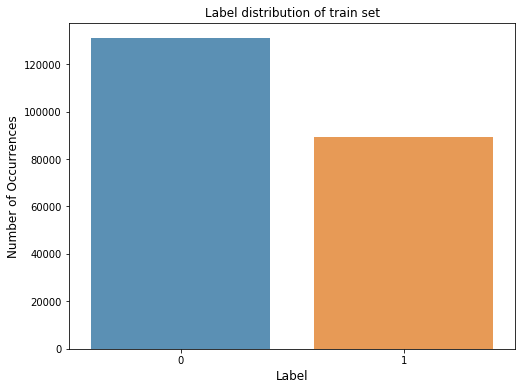

In [37]:
df_data = pd.read_csv('./data/train_labels.csv')
df_data['id'] = df_data['id'].astype(str) + '.tif'

df_data_test = pd.read_csv('./data/sample_submission.csv')
df_data_test['id'] = df_data_test['id'].astype(str) + '.tif'

label_count = df_data['label'].value_counts()
plt.figure(figsize=(8,6))
sns.barplot(label_count.index, label_count.values, alpha=0.8)
plt.title('Label distribution of train set')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.show()

Here, we visualize some data from the training set, and the corresponding label.

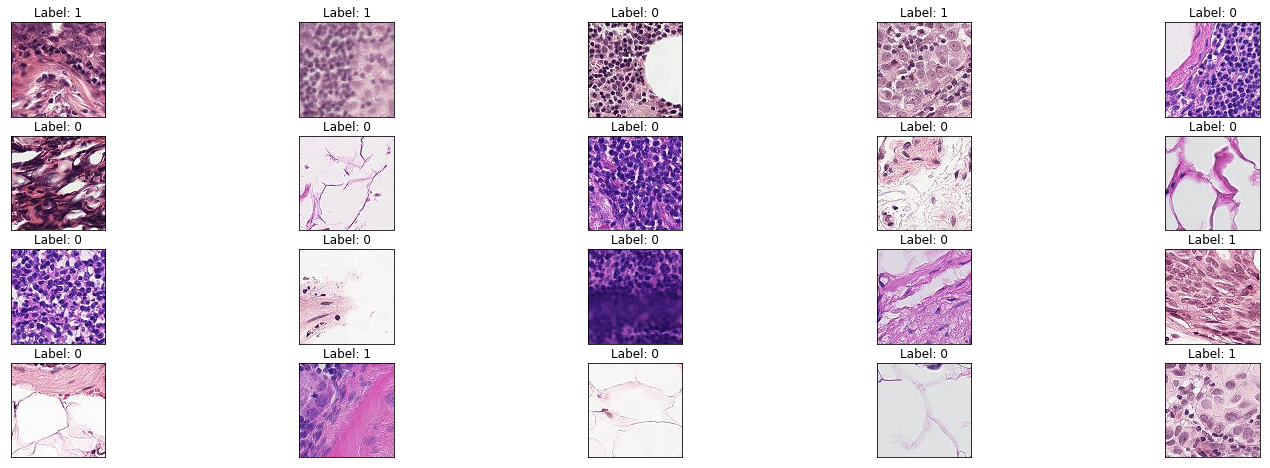

In [10]:
fig = plt.figure(figsize=(25, 8))
# display 20 images
train_imgs = os.listdir("./data/train")
for idx, img_name in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(4, 10//2, idx+1, xticks=[], yticks=[])
    im = Image.open("./data/train/" + img_name)
    plt.imshow(im)
    label = df_data.loc[df_data['id'] == img_name, 'label'].values[0]
    ax.set_title('Label: {}'.format(label))

Below, we create ImageDataGenerators for the train, validation, and test set.

In [38]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_data,
    directory='data/train/',
    target_size=DIMENSIONS,
    batch_size=32,
    x_col='id',
    y_col='label',
    class_mode='other',
    subset='training')

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df_data,
    directory='data/train/',
    target_size=DIMENSIONS,
    batch_size=32,
    x_col='id',
    y_col='label',
    class_mode='other',
    subset='validation')

test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_data_test,
    directory='data/test/',
    target_size=DIMENSIONS,
    batch_size=1,
    x_col='id',
    y_col='label',
    class_mode='other',
    seed=0,
    shuffle=False
)

Found 198023 validated image filenames.
Found 22002 validated image filenames.
Found 57458 validated image filenames.


## Create the Network
Next, we create the network using the Keras functional API.

In [29]:
inputs = Input(shape=(32,32,3,))

x = Dense(64, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
x = Flatten()(x)
predictions = Dense(1, activation='sigmoid')(x)

model.summary()

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
dense_45 (Dense)             (None, 32, 32, 64)        256       
_________________________________________________________________
dense_46 (Dense)             (None, 32, 32, 64)        4160      
_________________________________________________________________
flatten_7 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 65537     
Total params: 69,953
Trainable params: 69,953
Non-trainable params: 0
_________________________________________________________________


## Train the network
Next, we train the network. I've added multiple handy callbacks, such as TensorBoard, ModelCheckpoint, and EarlyStopping.

In [30]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
# modelcheckpoint = ModelCheckpoint(modelcheckpoint_name, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
# earlystopping = EarlyStopping(monitor='val_loss', patience=1)
model.fit_generator(train_generator, epochs=10, validation_data=validation_generator, callbacks=[tensorboard])

Epoch 1/10
6189/6189 [==============================] - 393s 64ms/step - loss: 0.4523 - acc: 0.7962 - val_loss: 0.3998 - val_acc: 0.8302
Epoch 2/10
6189/6189 [==============================] - 361s 58ms/step - loss: 0.3973 - acc: 0.8271 - val_loss: 0.4126 - val_acc: 0.8146
Epoch 3/10
6189/6189 [==============================] - 366s 59ms/step - loss: 0.3802 - acc: 0.8352 - val_loss: 0.3874 - val_acc: 0.8320
Epoch 4/10
6189/6189 [==============================] - 366s 59ms/step - loss: 0.3682 - acc: 0.8410 - val_loss: 0.3777 - val_acc: 0.8411
Epoch 5/10
6189/6189 [==============================] - 363s 59ms/step - loss: 0.3592 - acc: 0.8454 - val_loss: 0.3808 - val_acc: 0.8358
Epoch 6/10
1109/6189 [====>.........................] - ETA: 5:01 - loss: 0.3490 - acc: 0.8504

KeyboardInterrupt: 

## Make a prediction
Finally, we make a prediction. The prediction will be saved to [data/submission.csv](data/submission.csv).

In [42]:
prediction = model.predict_generator(test_generator, verbose=1)
submission = pd.read_csv('./data/sample_submission.csv')
submission['label'] = prediction
submission.to_csv('./data/submission.csv', index=False)


57458/57458 [==============================] - 67s 1ms/step
